In [6]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, plot_roc_curve

from copy import copy

from time import time

In [2]:
df = pd.read_csv('data/us census data.csv')

In [3]:
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,2174,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,0,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,0,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,0,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,0,<=50K


In [4]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,48842.0,NaN,NaN,NaN,38.643585,13.71051,17.0,28.0,37.0,48.0,90.0
workclass,48842,7,Private,33906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,48842.0,NaN,NaN,NaN,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education,48842,16,HS-grad,15784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital-status,48842,7,Married-civ-spouse,22379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,48842,15,Prof-specialty,6172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,48842,6,Husband,19716,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,48842,5,White,41762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,48842,2,Male,32650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hours-per-week,48842.0,NaN,NaN,NaN,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


In [5]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

ordinal_encoder = OrdinalEncoder(dtype=int)
label_encoder = LabelEncoder()

X_cat = X.iloc[:,np.where(X.dtypes == object)[0]]

X_enc_cat = ordinal_encoder.fit_transform(X_cat)
X_enc = copy(X)
X_enc.iloc[:,np.where(X.dtypes == object)[0]] = X_enc_cat
y_enc = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc,y_enc,test_size=0.2, random_state=1)

In [262]:
scoring = {'accuracy': make_scorer(accuracy_score),
           'f1': make_scorer(f1_score)}

parameters = {
    "learning_rate": [0.01,0.05,0.1],
    "max_depth":[2,3,4,5],
    "n_estimators": np.linspace(100,500,9,dtype=int)
}
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=5, n_jobs=-1)

clf.fit(X_train_enc, y_train_enc)
df=pd.DataFrame.from_dict(clf.cv_results_)

In [263]:
df.loc[df['mean_test_accuracy'].idxmax()]['params']

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 350}

In [8]:
start = time()
clf = GradientBoostingClassifier(learning_rate=0.1,max_depth=4,n_estimators=350)
clf.fit(X_train_enc,y_train_enc)
end = time()
print("Fitting time: ",end-start)
y_pred = clf.predict(X_test_enc)
accuracy_score(y_test_enc,y_pred)

Fitting time:  19.50012445449829


0.8709182106663937

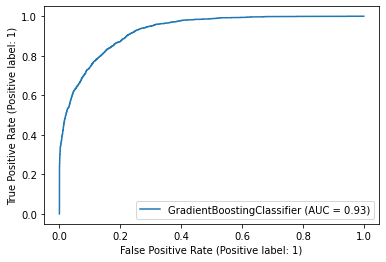

In [70]:
plot_roc_curve(clf,X_test_enc,y_test_enc)

In [71]:
confusion_matrix(y_test_enc,y_pred,normalize='true')

array([[0.94131898, 0.05868102],
       [0.35271484, 0.64728516]])

In [9]:
import catboost as cb

In [233]:
model = cb.CatBoostClassifier(logging_level='Silent',eval_metric = 'Accuracy',cat_features=[1,3,4,5,6,7,8,10])

grid = {
        'depth': [2, 3, 4, 5],
        'n_estimators': np.linspace(100,1000,9,dtype=int)
        }

grid_search_result = model.grid_search(grid,
                                       X=X_train,
                                       y=y_train,
                                       cv=5,
                                       verbose=False,
                                       plot=True
                                       )

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [234]:
grid_search_result['params']

{'depth': 4, 'iterations': 1000}

In [10]:
cat_features_indices = np.where(X_train.dtypes == object)[0]
train_dataset = cb.Pool(X_train,y_train,cat_features=cat_features_indices)
test_dataset = cb.Pool(X_test,y_test,cat_features=cat_features_indices)

In [14]:
start = time()
model = cb.CatBoostClassifier(logging_level='Silent',
                              cat_features=cat_features_indices,
                              depth=3,
                              iterations=100,
                              learning_rate=1.0,
                              eval_metric='Accuracy'
                              )
model.fit(train_dataset,eval_set=test_dataset,plot=False)
end = time()
print("Fitting time: ",end-start)

Fitting time:  1.9439704418182373


In [15]:
print(model.get_best_score())

{'learn': {'Accuracy': 0.8784070841757735, 'Logloss': 0.2700227796082597}, 'validation': {'Accuracy': 0.871839492271471, 'Logloss': 0.2800103775102453}}


# Catboost faster